## Results Mortality


In [1]:
import numpy as np
import pandas as pd
#from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib inline
import pickle
import palettable
from scipy.sparse import csr_matrix, vstack
from scipy.optimize import curve_fit
import sys 
from netCDF4 import num2date, date2num
import xarray as xr
from netCDF4 import Dataset

sys.path.append('../../')

from climada.engine import Impact
from climada.entity import Exposures
from climada.hazard import Hazard
from src.impact_calculation.impact_heat import *
from src.util.plots import *

fig_dir = '../../data_analysis/figures/'

2020-12-21 13:15:54,293 - climada - DEBUG - Loading default config file: /Users/zeliestalhanske/Documents/GitHub/climada_python/climada/conf/defaults.conf


In [32]:
directory_exposures = '../../input_data/exposures/'
exposures = {}
for code, category in {'O': 'Over 75', 'U': 'Under 75'}.items():    
    exposures_file = ''.join([directory_exposures, 'exposures_mortality_ch_', code,'2.h5'])
    exposures[category] = Exposures()
    exposures[category].read_hdf5(exposures_file)
    exposures[category]['value'] = exposures[category]['value']*exposures[category]['total_population_canton']

    #exposures[category] = Exposures(exposures[category])
    exposures[category].check()


2020-12-21 14:44:11,800 - climada.entity.exposures.base - INFO - Reading ../../input_data/exposures/exposures_mortality_ch_O2.h5
2020-12-21 14:44:14,070 - climada.entity.exposures.base - INFO - centr_ not set.
2020-12-21 14:44:14,070 - climada.entity.exposures.base - INFO - deductible not set.
2020-12-21 14:44:14,071 - climada.entity.exposures.base - INFO - cover not set.
2020-12-21 14:44:14,071 - climada.entity.exposures.base - INFO - category_id not set.
2020-12-21 14:44:14,072 - climada.entity.exposures.base - INFO - region_id not set.
2020-12-21 14:44:14,075 - climada.entity.exposures.base - INFO - Reading ../../input_data/exposures/exposures_mortality_ch_U2.h5
2020-12-21 14:44:16,190 - climada.entity.exposures.base - INFO - centr_ not set.
2020-12-21 14:44:16,191 - climada.entity.exposures.base - INFO - deductible not set.
2020-12-21 14:44:16,191 - climada.entity.exposures.base - INFO - cover not set.
2020-12-21 14:44:16,192 - climada.entity.exposures.base - INFO - category_id not

## Damage cost for each scenario, year and age category

In [27]:
pickle_in = \
open('../../output/mortality_results/impact_CH_values_1000mc.pickle','rb')
impacts_mortality = pickle.load(pickle_in)

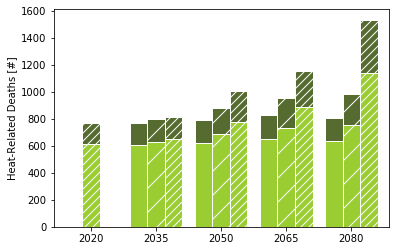

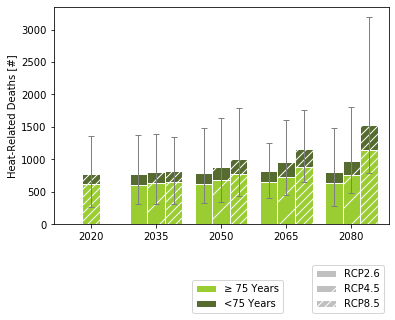

In [29]:
plot_impacts_heat(impacts_mortality.agg_impacts_mc, unit='Heat-Related Deaths [#]', impact_type='mortality', color=['yellowgreen', 'darkolivegreen'], labels_cat=['≥ 75 Years','<75 Years'], save=True)



In [24]:
impacts_mortality.agg_impacts_mc['RCP85'][2020]['Over 75'].median()-

648.350360702523

In [23]:
np.median(impacts_mortality.agg_impacts_mc['RCP85'][2080]['Over 75'])+np.median(impacts_mortality.agg_impacts_mc['RCP85'][2080]['Under 75'])-np.median(impacts_mortality.agg_impacts_mc['RCP26'][2080]['Over 75'])-np.median(impacts_mortality.agg_impacts_mc['RCP26'][2080]['Under 75'])


6.136357399216102e-06

In [60]:
def median_death(scenario, year, category='all'):
    if category=='all':
        median_death = (np.median(impacts_mortality.agg_impacts_mc[scenario][year]['Over 75'])+np.median(impacts_mortality.agg_impacts_mc[scenario][year]['Under 75']))
    else:    
        median_death = np.median(impacts_mortality.agg_impacts_mc[scenario][year][category])
    return median_death

def percentile_death(scenario, year, percentile, category='all'):
    if category=='all':
        median_death = (np.percentile(impacts_mortality.agg_impacts_mc[scenario][year]['Over 75'], percentile)+np.percentile(impacts_mortality.agg_impacts_mc[scenario][year]['Under 75'], percentile))
    else:    
        median_death = np.percentile(impacts_mortality.agg_impacts_mc[scenario][year][category],percentile)
    return median_death

def max_death(scenario, year, category='all'):
    if category=='all':
        median_death = (np.max(impacts_mortality.agg_impacts_mc[scenario][year]['Over 75'])+np.max(impacts_mortality.agg_impacts_mc[scenario][year]['Under 75']))
    else:    
        median_death = np.max(impacts_mortality.agg_impacts_mc[scenario][year][category])
    return median_death

In [64]:
print(percentile_death('RCP85', 2050, 40, category='all'))
print(percentile_death('RCP85', 2050, 60, category='all'))
print(median_death('RCP85', 2050))

print(median_death('RCP85', 2050) - percentile_death('RCP85', 2050, 90, category='all'))
print(median_death('RCP85', 2050) - percentile_death('RCP85', 2050, 95, category='all'))


891.8011733708153
1108.7626060228035
1011.126393352617
-534.887690098481
-777.6492570162791


In [63]:
percentile_death('RCP85', 2050, 5, category='all')

441.0985151426401

## Spatial Impact

2020-12-14 15:19:05,139 - climada.entity.exposures.base - INFO - centr_ not set.
2020-12-14 15:19:05,140 - climada.entity.exposures.base - INFO - deductible not set.
2020-12-14 15:19:05,141 - climada.entity.exposures.base - INFO - cover not set.
2020-12-14 15:19:05,142 - climada.entity.exposures.base - INFO - category_id not set.
2020-12-14 15:19:05,143 - climada.entity.exposures.base - INFO - region_id not set.
2020-12-14 15:19:16,334 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


/Users/zeliestalhanske/Documents/GitHub/climada_python/climada/util/plot.py:311: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


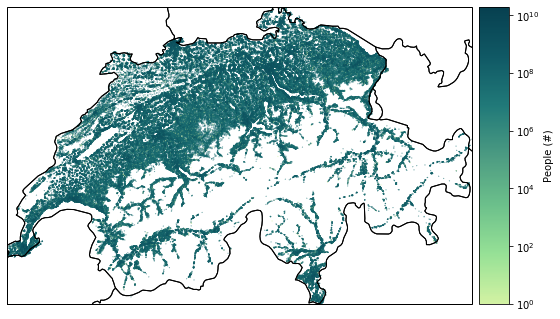

In [79]:
from climada.util.plot import make_map
import cartopy.crs as ccrs
import matplotlib
cm = palettable.cartocolors.sequential.Emrld_7.mpl_colormap

exposures['Under 75'].check()
exposures['Under 75'].to_crs(epsg=3785, inplace=True)

exposures['Under 75'].plot_hexbin(pop_name=False, cmap=cm, buffer=0.1, cbar_label='People (#)', norm=matplotlib.colors.LogNorm())
plt.savefig('../figures/map_exposures_ch_u75.pdf',bbox_inches='tight')   


2020-12-21 14:44:17,474 - climada.util.coordinates - INFO - Setting geometry points.
2020-12-21 14:44:29,825 - climada.entity.exposures.base - INFO - Setting if_ to default impact functions ids 1.
2020-12-21 14:44:29,827 - climada.entity.exposures.base - INFO - centr_ not set.
2020-12-21 14:44:29,828 - climada.entity.exposures.base - INFO - deductible not set.
2020-12-21 14:44:29,828 - climada.entity.exposures.base - INFO - cover not set.
2020-12-21 14:44:29,829 - climada.entity.exposures.base - INFO - category_id not set.
2020-12-21 14:44:29,830 - climada.entity.exposures.base - INFO - region_id not set.
2020-12-21 14:44:41,307 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


/Users/zeliestalhanske/Documents/GitHub/climada_python/climada/util/plot.py:311: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


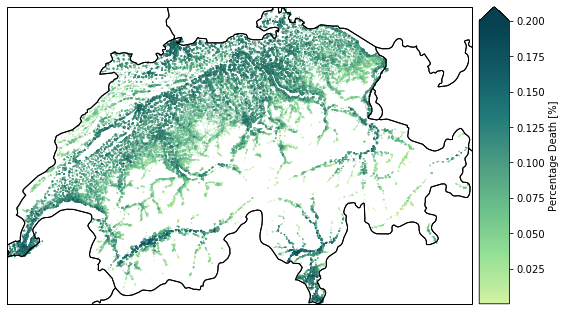

In [33]:
category = 'Over 75'
categories_code = {'Over 75':'O', 'Under 75':'U'}
cm = palettable.cartocolors.sequential.Emrld_7.mpl_colormap

impact = impacts_mortality.matrix_as_impact(impacts_mortality.median_impact_matrices['RCP85'][2050][category], exposures[category], percentage=True, unit='%')
impact.plot_hexbin_impact_exposure(pop_name=False, cmap=cm, vmax=0.2, extend='max', proj=3785, cbar_label='Percentage Death [%]')

plt.savefig(''.join([fig_dir,'spatial_impact_2050_o75.pdf']),bbox_inches='tight')

## Relative change map

2020-12-21 14:45:29,751 - climada.util.coordinates - INFO - Setting geometry points.


../../src/impact_calculation/impact_heat.py:156: RuntimeWarning: divide by zero encountered in true_divide
  matrix_rel = (np.nan_to_num((matrix.toarray() - matrix_ref.toarray()) / matrix_ref.toarray())) * 100
../../src/impact_calculation/impact_heat.py:156: RuntimeWarning: invalid value encountered in true_divide
  matrix_rel = (np.nan_to_num((matrix.toarray() - matrix_ref.toarray()) / matrix_ref.toarray())) * 100
../../src/impact_calculation/impact_heat.py:156: RuntimeWarning: overflow encountered in multiply
  matrix_rel = (np.nan_to_num((matrix.toarray() - matrix_ref.toarray()) / matrix_ref.toarray())) * 100


2020-12-21 14:45:42,207 - climada.entity.exposures.base - INFO - Setting if_ to default impact functions ids 1.
2020-12-21 14:45:42,209 - climada.entity.exposures.base - INFO - centr_ not set.
2020-12-21 14:45:42,210 - climada.entity.exposures.base - INFO - deductible not set.
2020-12-21 14:45:42,210 - climada.entity.exposures.base - INFO - cover not set.
2020-12-21 14:45:42,212 - climada.entity.exposures.base - INFO - category_id not set.
2020-12-21 14:45:42,212 - climada.entity.exposures.base - INFO - region_id not set.
2020-12-21 14:45:53,372 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


/Users/zeliestalhanske/Documents/GitHub/climada_python/climada/util/plot.py:311: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


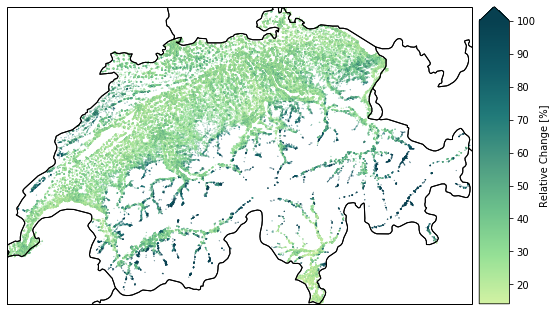

In [34]:
rel_mat = ImpactsHeatMortality.compute_relative_change(impacts_mortality.median_impact_matrices['RCP85'][2050][category], impacts_mortality.median_impact_matrices['RCP85'][2020][category])
impacts_rel = ImpactsHeatMortality.matrix_as_impact(rel_mat, exposures[category], unit='%')
impacts_rel.plot_hexbin_impact_exposure(pop_name=False, cmap=cm, buffer=0.1, vmax=100, extend='max', proj=3785, cbar_label='Relative Change [%]')

plt.savefig(''.join([fig_dir,'relative_changes_2020_2050_o75.pdf']),bbox_inches='tight')

2020-12-21 14:47:41,891 - climada.util.coordinates - INFO - Setting geometry points.


../../src/impact_calculation/impact_heat.py:156: RuntimeWarning: divide by zero encountered in true_divide
  matrix_rel = (np.nan_to_num((matrix.toarray() - matrix_ref.toarray()) / matrix_ref.toarray())) * 100
../../src/impact_calculation/impact_heat.py:156: RuntimeWarning: invalid value encountered in true_divide
  matrix_rel = (np.nan_to_num((matrix.toarray() - matrix_ref.toarray()) / matrix_ref.toarray())) * 100
../../src/impact_calculation/impact_heat.py:156: RuntimeWarning: overflow encountered in multiply
  matrix_rel = (np.nan_to_num((matrix.toarray() - matrix_ref.toarray()) / matrix_ref.toarray())) * 100


2020-12-21 14:47:53,724 - climada.entity.exposures.base - INFO - Setting if_ to default impact functions ids 1.
2020-12-21 14:47:53,727 - climada.entity.exposures.base - INFO - centr_ not set.
2020-12-21 14:47:53,728 - climada.entity.exposures.base - INFO - deductible not set.
2020-12-21 14:47:53,728 - climada.entity.exposures.base - INFO - cover not set.
2020-12-21 14:47:53,729 - climada.entity.exposures.base - INFO - category_id not set.
2020-12-21 14:47:53,730 - climada.entity.exposures.base - INFO - region_id not set.
2020-12-21 14:48:05,375 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


/Users/zeliestalhanske/Documents/GitHub/climada_python/climada/util/plot.py:311: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


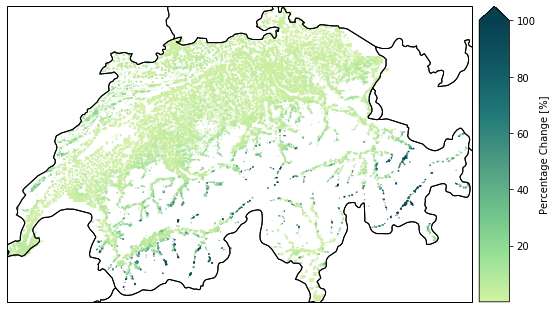

In [36]:
rel_mat = ImpactsHeatMortality.compute_relative_change(impacts_mortality.median_impact_matrices['RCP26'][2050][category], impacts_mortality.median_impact_matrices['RCP85'][2020][category])
impacts_rel = ImpactsHeatMortality.matrix_as_impact(rel_mat, exposures[category], unit='%')
impacts_rel.plot_hexbin_impact_exposure(pop_name=False, cmap=cm, buffer=0.1, vmax=100, extend='max', proj=3785, cbar_label='Percentage Change [%]')

plt.savefig(''.join([fig_dir,'relative_changes_2020_2050_o75_rcp26.pdf']),bbox_inches='tight')

## Make Table with Cantonal Values

In [51]:
cantonal_impacts_df = impacts_mortality.median_impact_matrices['RCP26'][2020]=impacts_mortality.median_impact_matrices['RCP26'][2080]
cantonal_impacts_df = impacts_mortality.median_impact_matrices['RCP45'][2020]=impacts_mortality.median_impact_matrices['RCP45'][2080]

cantonal_impacts_df = impacts_mortality.cantonal_impacts_df(exposures, scenarios=['RCP26', 'RCP85'], years=[2020,2050,2080], categories_short=categories_short)


In [65]:
cantonal_impacts_df_rcp45 = impacts_mortality.cantonal_impacts_df(exposures, scenarios=['RCP45'], years=[2020,2050,2080], categories_short=categories_short)


In [66]:
cantonal_impacts_df_rcp45

RCP4.5                                      \
                              2020                    2050               
                               ≥75         <75         ≥75         <75   
canton                                                                   
Aargau                   62.617195   20.713594   57.025645   18.620369   
Appenzell Ausserrhoden    3.278069    0.822778    2.880859    0.701739   
Appenzell Innerrhoden     0.995889    0.246478    0.876406    0.209539   
Basel-Landschaft         32.756626    8.128244   30.177766    7.362230   
Basel-Stadt              18.630839    4.740279   17.296493    4.353832   
Bern                     98.923101   26.463953   89.003432   22.923339   
Fribourg                 23.559202    8.706994   21.317407    7.545115   
Genève                   43.761429   15.792411   39.652429   13.858248   
Glarus                    3.106981    0.808227    2.727083    0.672091   
Graubünden               16.534948    4.433725   13.992226    3.580356   
Jura                      7.993631    2.173312    7.220691    1.910575   
Luzern                   32.349220   10.167546   29.415212    8.909843   
Neuchâtel                13.096982    3.407983   11.819339    2.964521   
Nidwalden                 3.706248    1.012291    3.336434    0.870012   
Obwalden                  2.878751    0.879672    2.546480    0.748232   
Schaffhausen              8.651524    2.344329    7.945288    2.105645   
Schwyz                   10.586384    3.127133    9.524724    2.681684   
Solothurn                29.201766    8.593081   26.629049    7.705516   
St. Gallen               39.257903   11.569592   35.030578    9.937062   
Thurgau                  22.751806    7.369442   20.666274    6.463903   
Ticino                   50.607608   11.525724   46.436934    9.954376   
Uri                       2.758005    0.725046    2.394753    0.597045   
Valais                   35.189310   10.886819   30.644554    9.058321   
Vaud                     62.018259   19.343944   56.512251   16.759446   
Zug                       8.062462    2.564968    7.324582    2.258645   
Zürich                  117.663774   35.833501  106.671122   31.805735   
Total                   750.937911  222.381065  679.068011  194.557416   

                                                
                              2080              
                               ≥75         <75  
canton                                          
Aargau                   62.617195   20.713594  
Appenzell Ausserrhoden    3.278069    0.822778  
Appenzell Innerrhoden     0.995889    0.246478  
Basel-Landschaft         32.756626    8.128244  
Basel-Stadt              18.630839    4.740279  
Bern                     98.923101   26.463953  
Fribourg                 23.559202    8.706994  
Genève                   43.761429   15.792411  
Glarus                    3.106981    0.808227  
Graubünden               16.534948    4.433725  
Jura                      7.993631    2.173312  
Luzern                   32.349220   10.167546  
Neuchâtel                13.096982    3.407983  
Nidwalden                 3.706248    1.012291  
Obwalden                  2.878751    0.879672  
Schaffhausen              8.651524    2.344329  
Schwyz                   10.586384    3.127133  
Solothurn                29.201766    8.593081  
St. Gallen               39.257903   11.569592  
Thurgau                  22.751806    7.369442  
Ticino                   50.607608   11.525724  
Uri                       2.758005    0.725046  
Valais                   35.189310   10.886819  
Vaud                     62.018259   19.343944  
Zug                       8.062462    2.564968  
Zürich                  117.663774   35.833501  
Total                   750.937911  222.381065

In [52]:
cantonal_impacts_df

RCP2.6                                      \
                              2020                    2050               
                               ≥75         <75         ≥75         <75   
canton                                                                   
Aargau                   53.123369   16.438713   52.000732   15.845084   
Appenzell Ausserrhoden    2.604746    0.610955    2.489217    0.551417   
Appenzell Innerrhoden     0.786216    0.182206    0.755671    0.164185   
Basel-Landschaft         28.201143    6.601168   27.542470    6.382621   
Basel-Stadt              16.026510    3.864053   15.749156    3.800027   
Bern                     82.421684   20.216176   80.706739   19.522291   
Fribourg                 19.799696    6.703891   19.238168    6.364952   
Genève                   35.886443   11.664955   36.067333   11.694499   
Glarus                    2.453261    0.568208    2.401480    0.549578   
Graubünden               12.507419    3.006374   12.372987    2.928961   
Jura                      6.731431    1.706282    6.611655    1.646589   
Luzern                   27.045680    7.746027   26.683774    7.395560   
Neuchâtel                10.998468    2.690915   10.605819    2.541507   
Nidwalden                 3.058837    0.750875    3.019262    0.721977   
Obwalden                  2.302338    0.636317    2.267492    0.614987   
Schaffhausen              7.404672    1.882055    7.231397    1.794868   
Schwyz                    8.710999    2.340147    8.545982    2.229879   
Solothurn                25.018394    6.847001   24.381216    6.636409   
St. Gallen               32.355595    8.714916   31.550627    8.255461   
Thurgau                  19.189694    5.751258   18.748087    5.489156   
Ticino                   42.816626    8.933799   43.450430    8.784665   
Uri                       2.195724    0.511974    2.154654    0.498945   
Valais                   27.396498    7.657594   27.926594    7.871642   
Vaud                     52.382089   14.941470   51.316476   14.296832   
Zug                       6.733088    1.963113    6.619244    1.869367   
Zürich                   99.404875   27.809813   97.677232   26.858985   
Total                   627.555494  170.740256  618.113893  165.310443   

                                                    RCP8.5              \
                              2080                    2020               
                               ≥75         <75         ≥75         <75   
canton                                                                   
Aargau                   53.123369   16.438713   51.180755   14.421867   
Appenzell Ausserrhoden    2.604746    0.610955    2.379631    0.544141   
Appenzell Innerrhoden     0.786216    0.182206    0.718172    0.159919   
Basel-Landschaft         28.201143    6.601168   27.025191    5.784799   
Basel-Stadt              16.026510    3.864053   15.648654    3.438239   
Bern                     82.421684   20.216176   78.763896   17.848046   
Fribourg                 19.799696    6.703891   18.881098    5.915449   
Genève                   35.886443   11.664955   34.728217   10.538641   
Glarus                    2.453261    0.568208    2.314782    0.507676   
Graubünden               12.507419    3.006374   11.373454    2.580097   
Jura                      6.731431    1.706282    6.362373    1.479258   
Luzern                   27.045680    7.746027   25.974485    6.877935   
Neuchâtel                10.998468    2.690915   10.330739    2.333024   
Nidwalden                 3.058837    0.750875    2.902662    0.662185   
Obwalden                  2.302338    0.636317    2.150007    0.558180   
Schaffhausen              7.404672    1.882055    7.144372    1.653906   
Schwyz                    8.710999    2.340147    8.255929    2.075024   
Solothurn                25.018394    6.847001   24.059755    6.006010   
St. Gallen               32.355595    8.714916   30.930570    7.821803   
Thurgau                  19.189

In [53]:
cantonal_impacts_df_total = cantonal_impacts_df.groupby(level=[0,1], axis=1).sum().astype(int)

In [54]:
cantonal_impacts_df_total

RCP2.6           RCP8.5           
                         2020 2050 2080   2020 2050  2080
canton                                                   
Aargau                     69   67   69     65   85   131
Appenzell Ausserrhoden      3    3    3      2    4     6
Appenzell Innerrhoden       0    0    0      0    1     2
Basel-Landschaft           34   33   34     32   42    64
Basel-Stadt                19   19   19     19   24    36
Bern                      102  100  102     96  127   194
Fribourg                   26   25   26     24   32    50
Genève                     47   47   47     45   59    95
Glarus                      3    2    3      2    3     6
Graubünden                 15   15   15     13   20    34
Jura                        8    8    8      7   10    16
Luzern                     34   34   34     32   43    67
Neuchâtel                  13   13   13     12   16    25
Nidwalden                   3    3    3      3    4     7
Obwalden                    2    2    2      2    3     6
Schaffhausen                9    9    9      8   11    17
Schwyz                     11   10   11     10   13    21
Solothurn                  31   31   31     30   38    58
St. Gallen                 41   39   41     38   51    79
Thurgau                    24   24   24     23   30    47
Ticino                     51   52   51     51   62    90
Uri                         2    2    2      2    3     5
Valais                     35   35   35     33   46    73
Vaud                       67   65   67     64   83   123
Zug                         8    8    8      8   10    16
Zürich                    127  124  127    121  156   241
Total                     798  783  798    756  991  1519

In [55]:
cantonal_impacts_df_total.insert(0, 'Baseline (2020)', cantonal_impacts_df_total['RCP8.5'][2020])

In [ ]:
cantonal_impacts_df['RCP8.5'][2020]['≥75']/(cantonal_impacts_df['RCP8.5'][2020]['≥75']+cantonal_impacts_df['RCP8.5'][2020]['<75'])
                                                                                                                           

In [59]:
cantonal_impacts_df

RCP2.6                                      \
                              2020                    2050               
                               ≥75         <75         ≥75         <75   
canton                                                                   
Aargau                   53.123369   16.438713   52.000732   15.845084   
Appenzell Ausserrhoden    2.604746    0.610955    2.489217    0.551417   
Appenzell Innerrhoden     0.786216    0.182206    0.755671    0.164185   
Basel-Landschaft         28.201143    6.601168   27.542470    6.382621   
Basel-Stadt              16.026510    3.864053   15.749156    3.800027   
Bern                     82.421684   20.216176   80.706739   19.522291   
Fribourg                 19.799696    6.703891   19.238168    6.364952   
Genève                   35.886443   11.664955   36.067333   11.694499   
Glarus                    2.453261    0.568208    2.401480    0.549578   
Graubünden               12.507419    3.006374   12.372987    2.928961   
Jura                      6.731431    1.706282    6.611655    1.646589   
Luzern                   27.045680    7.746027   26.683774    7.395560   
Neuchâtel                10.998468    2.690915   10.605819    2.541507   
Nidwalden                 3.058837    0.750875    3.019262    0.721977   
Obwalden                  2.302338    0.636317    2.267492    0.614987   
Schaffhausen              7.404672    1.882055    7.231397    1.794868   
Schwyz                    8.710999    2.340147    8.545982    2.229879   
Solothurn                25.018394    6.847001   24.381216    6.636409   
St. Gallen               32.355595    8.714916   31.550627    8.255461   
Thurgau                  19.189694    5.751258   18.748087    5.489156   
Ticino                   42.816626    8.933799   43.450430    8.784665   
Uri                       2.195724    0.511974    2.154654    0.498945   
Valais                   27.396498    7.657594   27.926594    7.871642   
Vaud                     52.382089   14.941470   51.316476   14.296832   
Zug                       6.733088    1.963113    6.619244    1.869367   
Zürich                   99.404875   27.809813   97.677232   26.858985   
Total                   627.555494  170.740256  618.113893  165.310443   

                                                    RCP8.5              \
                              2080                    2020               
                               ≥75         <75         ≥75         <75   
canton                                                                   
Aargau                   53.123369   16.438713   51.180755   14.421867   
Appenzell Ausserrhoden    2.604746    0.610955    2.379631    0.544141   
Appenzell Innerrhoden     0.786216    0.182206    0.718172    0.159919   
Basel-Landschaft         28.201143    6.601168   27.025191    5.784799   
Basel-Stadt              16.026510    3.864053   15.648654    3.438239   
Bern                     82.421684   20.216176   78.763896   17.848046   
Fribourg                 19.799696    6.703891   18.881098    5.915449   
Genève                   35.886443   11.664955   34.728217   10.538641   
Glarus                    2.453261    0.568208    2.314782    0.507676   
Graubünden               12.507419    3.006374   11.373454    2.580097   
Jura                      6.731431    1.706282    6.362373    1.479258   
Luzern                   27.045680    7.746027   25.974485    6.877935   
Neuchâtel                10.998468    2.690915   10.330739    2.333024   
Nidwalden                 3.058837    0.750875    2.902662    0.662185   
Obwalden                  2.302338    0.636317    2.150007    0.558180   
Schaffhausen              7.404672    1.882055    7.144372    1.653906   
Schwyz                    8.710999    2.340147    8.255929    2.075024   
Solothurn                25.018394    6.847001   24.059755    6.006010   
St. Gallen               32.355595    8.714916   30.930570    7.821803   
Thurgau                  19.189

In [56]:
with pd.option_context("max_colwidth", 1000):
    print(cantonal_impacts_df_total.to_latex(multicolumn=True))


\begin{tabular}{lrrrrrrr}
\toprule
{} & Baseline (2020) & \multicolumn{3}{l}{RCP2.6} & \multicolumn{3}{l}{RCP8.5} \\
{} &   2020 & 2050 & 2080 &   2020 & 2050 &  2080 \\
canton                 &                 &        &      &      &        &      &       \\
\midrule
Aargau                 &              65 &     69 &   67 &   69 &     65 &   85 &   131 \\
Appenzell Ausserrhoden &               2 &      3 &    3 &    3 &      2 &    4 &     6 \\
Appenzell Innerrhoden  &               0 &      0 &    0 &    0 &      0 &    1 &     2 \\
Basel-Landschaft       &              32 &     34 &   33 &   34 &     32 &   42 &    64 \\
Basel-Stadt            &              19 &     19 &   19 &   19 &     19 &   24 &    36 \\
Bern                   &              96 &    102 &  100 &  102 &     96 &  127 &   194 \\
Fribourg               &              24 &     26 &   25 &   26 &     24 &   32 &    50 \\
Genève                 &              45 &     47 &   47 &   47 &     45 &   59 &    95 \\
Gl

In [57]:
cantonal_impacts_df_total = cantonal_impacts_df_total.drop(columns=2020,level=1)

In [ ]:
(cantonal_impacts_df_total['RCP8.5'][2080]-cantonal_impacts_df_total['RCP2.6'][2080])

In [101]:
cantonal_impacts_df_total['RCP2.6'][2080]

canton
Aargau                     69
Appenzell Ausserrhoden      3
Appenzell Innerrhoden       0
Basel-Landschaft           34
Basel-Stadt                19
Bern                      100
Fribourg                   26
Genève                     47
Glarus                      2
Graubünden                 15
Jura                        8
Luzern                     33
Neuchâtel                  13
Nidwalden                   3
Obwalden                    2
Schaffhausen                9
Schwyz                     10
Solothurn                  31
St. Gallen                 40
Thurgau                    23
Ticino                     51
Uri                         2
Valais                     35
Vaud                       66
Zug                         8
Zürich                    123
Total                     787
Name: 2080, dtype: int64

In [ ]:
(cantonal_impacts_df_total['RCP8.5'][2080]-cantonal_impacts_df_total['RCP2.6'][2080])/(cantonal_impacts_df_total['RCP2.6'][2080])




In [67]:
cantonal_impacts_df_total

Baseline (2020) RCP2.6      RCP8.5      
                                         2050 2080   2050  2080
canton                                                         
Aargau                              65     67   69     85   131
Appenzell Ausserrhoden               2      3    3      4     6
Appenzell Innerrhoden                0      0    0      1     2
Basel-Landschaft                    32     33   34     42    64
Basel-Stadt                         19     19   19     24    36
Bern                                96    100  102    127   194
Fribourg                            24     25   26     32    50
Genève                              45     47   47     59    95
Glarus                               2      2    3      3     6
Graubünden                          13     15   15     20    34
Jura                                 7      8    8     10    16
Luzern                              32     34   34     43    67
Neuchâtel                           12     13   13     16    25
Nidwalden                            3      3    3      4     7
Obwalden                             2      2    2      3     6
Schaffhausen                         8      9    9     11    17
Schwyz                              10     10   11     13    21
Solothurn                           30     31   31     38    58
St. Gallen                          38     39   41     51    79
Thurgau                             23     24   24     30    47
Ticino                              51     52   51     62    90
Uri                                  2      2    2      3     5
Valais                              33     35   35     46    73
Vaud                                64     65   67     83   123
Zug                                  8      8    8     10    16
Zürich                             121    124  127    156   241
Total                              756    783  798    991  1519

In [58]:
with pd.option_context("max_colwidth", 1000):
    print(cantonal_impacts_df_total.to_latex(multicolumn=True))


\begin{tabular}{lrrrrr}
\toprule
{} & Baseline (2020) & \multicolumn{2}{l}{RCP2.6} & \multicolumn{2}{l}{RCP8.5} \\
{} &   2050 & 2080 &   2050 &  2080 \\
canton                 &                 &        &      &        &       \\
\midrule
Aargau                 &              65 &     67 &   69 &     85 &   131 \\
Appenzell Ausserrhoden &               2 &      3 &    3 &      4 &     6 \\
Appenzell Innerrhoden  &               0 &      0 &    0 &      1 &     2 \\
Basel-Landschaft       &              32 &     33 &   34 &     42 &    64 \\
Basel-Stadt            &              19 &     19 &   19 &     24 &    36 \\
Bern                   &              96 &    100 &  102 &    127 &   194 \\
Fribourg               &              24 &     25 &   26 &     32 &    50 \\
Genève                 &              45 &     47 &   47 &     59 &    95 \\
Glarus                 &               2 &      2 &    3 &      3 &     6 \\
Graubünden             &              13 &     15 &   15 &     20 &